Download the dataset from here: 
https://drive.google.com/file/d/1lUmzcMUFJSF60DFMK5yKQClGqg9v8fcP/view?usp=sharing
And extract it into your working directory

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import numpy as np

In [47]:
# tf.enable_eager_execution()
image_dir = "dataset_X/"
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]
print(len(images))
images[:2]

9014


['dataset_X/8518.png', 'dataset_X/576.png']

In [48]:
# preprocess
image_size = 64
@tf.function
def preprocess(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image = image / 255.0
    image = tf.reshape(image, shape = (image_size, image_size, 1,))
    return image

In [49]:
batch_size = 128

training_dataset = tf.data.Dataset.from_tensor_slices((images))
training_dataset = training_dataset.map(preprocess)
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

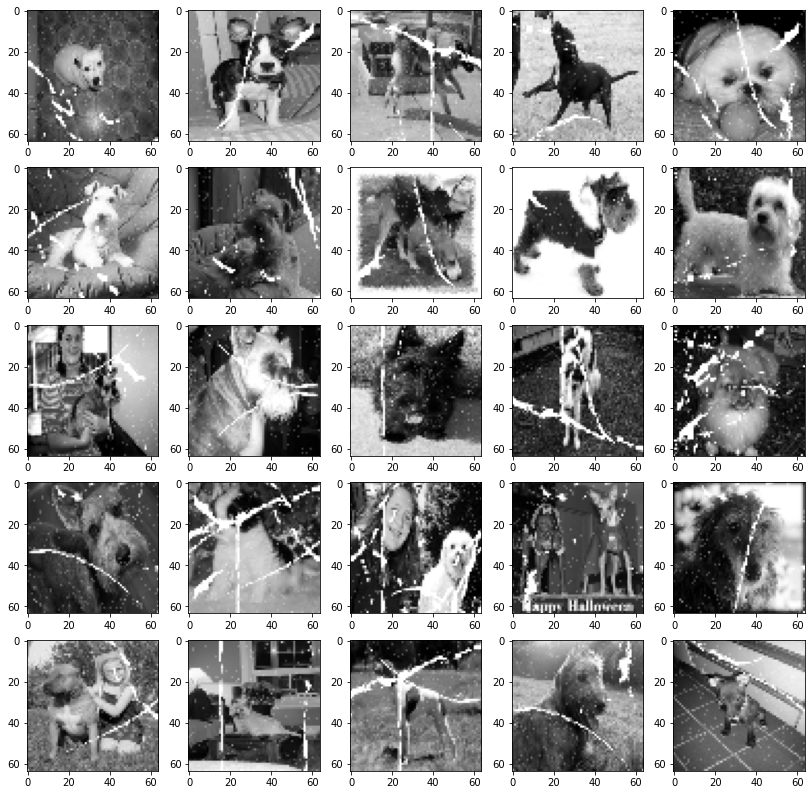

In [72]:
# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx], cmap='gray')
        idx+=1

In [73]:
# build the model
# tf.compat.v1.disable_eager_execution()
latent_dim = 512

In [74]:
from tensorflow.keras.models import Sequential, Model

import tensorflow.keras
from tensorflow.keras import *

from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.activations import selu
from tensorflow.keras.layers import Multiply, Add
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import backend as K

In [75]:
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import display,Markdown


# Note : https://keras.io/guides/making_new_layers_and_models_via_subclassing/

class SamplingLayer(keras.layers.Layer):
    '''A custom layer that receive (z_mean, z_var) and sample a z vector'''

    def call(self, inputs):
        
        z_mean, z_log_var = inputs
        
        batch_size = tf.shape(z_mean)[0]
        latent_dim = tf.shape(z_mean)[1]
        
        epsilon = keras.backend.random_normal(shape=(batch_size, latent_dim))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z


In [76]:
print(tf.__version__)
print(keras.__version__)

2.0.0
2.2.4-tf


In [77]:
K.clear_session()

In [78]:
encoder_input    = tf.keras.Input(shape=(64,64,1))
x         = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(encoder_input)
x         = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(512, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(1024, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

z         = SamplingLayer()([z_mean, z_log_var])

encoder = tf.keras.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 128)  36992       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 256)    295168      conv2d_1[0][0]                   
____________________________________________________________________________________________

In [80]:
# build the decoder

decoder = Sequential()
decoder.add(Dense(1024, activation = selu, input_shape = (latent_dim, )))
decoder.add(BatchNormalization())

decoder.add(Dense(8192, activation = selu))
decoder.add(Reshape((4,4,512)))

decoder.add(Conv2DTranspose(256, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(128, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(1, (5,5), activation = "sigmoid", strides = 1, padding = 'same'))
decoder.add(BatchNormalization())

decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_2 (Dense)              (None, 8192)              8396800   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       8

In [81]:
# make loss function 
# vae loss = reconstruction loss + KL div

def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return loss

def vae_loss(y_true, y_pred, mu, log_var):
    return reconstruction_loss(y_true, y_pred) + (1 / (64*64)) * kl_loss(mu, log_var)

In [82]:
# conbine encoder and decoder
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)
model = Model(encoder_input, reconstructed, name ="vae")
loss = kl_loss(mu, log_var)
model.add_loss(loss)
model.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 512), (None, 10951872    input_1[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64, 64, 1)    13281413    encoder[1][2]                    
__________________________________________________________________________________________________
tf_op_layer_add (TensorFlowOpLa [(None, 512)]        0           encoder[1][1]                    
________________________________________________________________________________________________

In [83]:
# make a function to save images while learning
import matplotlib.pyplot as plt
def save_images(model, epoch, step, input_):
    prediction = model.predict(input_, steps = 5)
    fig, axes = plt.subplots(5,5, figsize = (14,14))
    idx = 0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype("int32")
            axes[row, column].imshow(image, cmap='gray')
            axes[row, column].axis("off")
            idx+=1
    print(prediction)
    output_path = "output/"
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + "Epoch_{:04d}_step_{:04d}.jpg".format(epoch, step))
    plt.close()

In [84]:
# train vae

from tensorflow.keras.optimizers import Adam

random_vector = tf.random.normal(shape = (25, latent_dim,))
save_images(decoder, 0, 0, random_vector)

mse_losses = []
kl_losses = []


optimizer = Adam(0.0001, 0.5)
epochs = 40
# execution_epoch(epochs,optimizer,model,training_dataset)
for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step,training_batch in enumerate(training_dataset.take(11)):
        with tf.GradientTape() as tape:
            reconstructed = model(training_batch)
            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])
            
            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())
            
            kl = sum(model.losses)
            kl_losses.append(kl.numpy())
            
            train_loss = 0.01 * kl + mse_loss
            
            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            if step % 10 == 0:
                save_images(decoder, epoch, step, random_vector)
            print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))

[[[[0.499604  ]
   [0.49985874]
   [0.4997064 ]
   ...
   [0.5000091 ]
   [0.5003788 ]
   [0.49997485]]

  [[0.49966803]
   [0.5000969 ]
   [0.4988524 ]
   ...
   [0.4999391 ]
   [0.50110817]
   [0.49881825]]

  [[0.49947268]
   [0.4996947 ]
   [0.50026655]
   ...
   [0.49777457]
   [0.4996111 ]
   [0.50098795]]

  ...

  [[0.49930266]
   [0.4990281 ]
   [0.49911323]
   ...
   [0.4907012 ]
   [0.50156784]
   [0.49912414]]

  [[0.49867886]
   [0.49928164]
   [0.49792665]
   ...
   [0.49935374]
   [0.49659935]
   [0.50055325]]

  [[0.499304  ]
   [0.49871334]
   [0.49925873]
   ...
   [0.49904788]
   [0.49975306]
   [0.49771383]]]


 [[[0.499699  ]
   [0.49977106]
   [0.499675  ]
   ...
   [0.5001934 ]
   [0.49956045]
   [0.49945927]]

  [[0.49989966]
   [0.50014174]
   [0.49896508]
   ...
   [0.49979135]
   [0.5013166 ]
   [0.4998171 ]]

  [[0.49969986]
   [0.5001545 ]
   [0.499534  ]
   ...
   [0.49912947]
   [0.5000227 ]
   [0.50048274]]

  ...

  [[0.4997839 ]
   [0.4976397 ]
   [0.4

Epoch: 1 - Step: 8 - MSE loss: 0.06480403 - KL loss: 0.00012432237
Epoch: 1 - Step: 9 - MSE loss: 0.06914462 - KL loss: 0.000117307965
[[[[0.49804175]
   [0.49766198]
   [0.4966621 ]
   ...
   [0.49697968]
   [0.49740607]
   [0.49735332]]

  [[0.4973015 ]
   [0.4969146 ]
   [0.4946074 ]
   ...
   [0.49505204]
   [0.4972405 ]
   [0.49527287]]

  [[0.49690914]
   [0.49616075]
   [0.49536282]
   ...
   [0.49211317]
   [0.49488991]
   [0.49747458]]

  ...

  [[0.49618512]
   [0.4947585 ]
   [0.4928783 ]
   ...
   [0.4822553 ]
   [0.4922669 ]
   [0.49374834]]

  [[0.49654287]
   [0.49482852]
   [0.49399778]
   ...
   [0.4910506 ]
   [0.49019152]
   [0.49656543]]

  [[0.4968389 ]
   [0.49470875]
   [0.49421194]
   ...
   [0.49151608]
   [0.49368662]
   [0.49370173]]]


 [[[0.49822617]
   [0.49783164]
   [0.49688813]
   ...
   [0.4974793 ]
   [0.49665415]
   [0.4971961 ]]

  [[0.49732423]
   [0.49694437]
   [0.49490526]
   ...
   [0.4946392 ]
   [0.49779263]
   [0.4959966 ]]

  [[0.49714077]


Epoch: 2 - Step: 5 - MSE loss: 0.06579251 - KL loss: 8.418843e-05
Epoch: 2 - Step: 6 - MSE loss: 0.06534973 - KL loss: 8.518464e-05
Epoch: 2 - Step: 7 - MSE loss: 0.06980246 - KL loss: 8.276295e-05
Epoch: 2 - Step: 8 - MSE loss: 0.06615322 - KL loss: 7.96751e-05
Epoch: 2 - Step: 9 - MSE loss: 0.06514711 - KL loss: 7.161953e-05
[[[[0.4973591 ]
   [0.49661377]
   [0.49548036]
   ...
   [0.49561113]
   [0.49606586]
   [0.4963346 ]]

  [[0.4963075 ]
   [0.49560398]
   [0.49274775]
   ...
   [0.4934207 ]
   [0.49623945]
   [0.4942222 ]]

  [[0.49588674]
   [0.4944692 ]
   [0.49357852]
   ...
   [0.48987725]
   [0.4932901 ]
   [0.4961762 ]]

  ...

  [[0.49520257]
   [0.49334344]
   [0.49102414]
   ...
   [0.48114192]
   [0.48972747]
   [0.49473134]]

  [[0.49609563]
   [0.49341604]
   [0.49298617]
   ...
   [0.4898089 ]
   [0.49066073]
   [0.49665093]]

  [[0.49623457]
   [0.4936953 ]
   [0.49303985]
   ...
   [0.49060404]
   [0.49294072]
   [0.49381742]]]


 [[[0.49750867]
   [0.49689978]


Epoch: 3 - Step: 2 - MSE loss: 0.06500524 - KL loss: 6.223266e-05
Epoch: 3 - Step: 3 - MSE loss: 0.066884175 - KL loss: 6.045134e-05
Epoch: 3 - Step: 4 - MSE loss: 0.06888927 - KL loss: 6.136666e-05
Epoch: 3 - Step: 5 - MSE loss: 0.06447457 - KL loss: 5.552549e-05
Epoch: 3 - Step: 6 - MSE loss: 0.068480484 - KL loss: 5.366918e-05
Epoch: 3 - Step: 7 - MSE loss: 0.0691179 - KL loss: 5.347278e-05
Epoch: 3 - Step: 8 - MSE loss: 0.06559335 - KL loss: 5.1073235e-05
Epoch: 3 - Step: 9 - MSE loss: 0.06500566 - KL loss: 4.997908e-05
[[[[0.49644712]
   [0.49541265]
   [0.49370143]
   ...
   [0.49364734]
   [0.49409387]
   [0.4950462 ]]

  [[0.4949219 ]
   [0.49379128]
   [0.48982742]
   ...
   [0.49023876]
   [0.49429664]
   [0.49262184]]

  [[0.4942844 ]
   [0.49227685]
   [0.49064732]
   ...
   [0.48609552]
   [0.49011922]
   [0.49452206]]

  ...

  [[0.49356055]
   [0.49070218]
   [0.4879223 ]
   ...
   [0.47663996]
   [0.48550704]
   [0.4936405 ]]

  [[0.49488807]
   [0.49132347]
   [0.49064

Epoch: 4 - Step: 1 - MSE loss: 0.070644096 - KL loss: 4.8186288e-05
Epoch: 4 - Step: 2 - MSE loss: 0.06762662 - KL loss: 4.4758723e-05
Epoch: 4 - Step: 3 - MSE loss: 0.06772116 - KL loss: 4.5824858e-05
Epoch: 4 - Step: 4 - MSE loss: 0.06727369 - KL loss: 4.21285e-05
Epoch: 4 - Step: 5 - MSE loss: 0.067515515 - KL loss: 4.1834635e-05
Epoch: 4 - Step: 6 - MSE loss: 0.06304773 - KL loss: 4.2689862e-05
Epoch: 4 - Step: 7 - MSE loss: 0.067949034 - KL loss: 4.0647457e-05
Epoch: 4 - Step: 8 - MSE loss: 0.06609599 - KL loss: 4.192079e-05
Epoch: 4 - Step: 9 - MSE loss: 0.06700455 - KL loss: 3.9825816e-05
[[[[0.49582544]
   [0.49484506]
   [0.49283764]
   ...
   [0.49293172]
   [0.4933117 ]
   [0.49453205]]

  [[0.49400532]
   [0.49289095]
   [0.4884442 ]
   ...
   [0.48934093]
   [0.493631  ]
   [0.4921668 ]]

  [[0.49340072]
   [0.4912899 ]
   [0.48955035]
   ...
   [0.4852113 ]
   [0.48923156]
   [0.4939618 ]]

  ...

  [[0.49282157]
   [0.4902881 ]
   [0.4876759 ]
   ...
   [0.4789061 ]
   [

Epoch: 5 - Step: 1 - MSE loss: 0.06279368 - KL loss: 3.6827056e-05
Epoch: 5 - Step: 2 - MSE loss: 0.0684171 - KL loss: 3.749123e-05
Epoch: 5 - Step: 3 - MSE loss: 0.06736408 - KL loss: 3.697741e-05
Epoch: 5 - Step: 4 - MSE loss: 0.06921691 - KL loss: 3.552794e-05
Epoch: 5 - Step: 5 - MSE loss: 0.066438325 - KL loss: 3.5513043e-05
Epoch: 5 - Step: 6 - MSE loss: 0.06643936 - KL loss: 3.3499553e-05
Epoch: 5 - Step: 7 - MSE loss: 0.07153432 - KL loss: 3.5568683e-05
Epoch: 5 - Step: 8 - MSE loss: 0.06591288 - KL loss: 3.2453383e-05
Epoch: 5 - Step: 9 - MSE loss: 0.065377705 - KL loss: 3.133227e-05
[[[[0.4950876 ]
   [0.49391112]
   [0.49165553]
   ...
   [0.49165848]
   [0.49209508]
   [0.49373314]]

  [[0.492779  ]
   [0.49148983]
   [0.48610318]
   ...
   [0.4870067 ]
   [0.4918527 ]
   [0.49080673]]

  [[0.492139  ]
   [0.48963854]
   [0.48733595]
   ...
   [0.48263085]
   [0.48696548]
   [0.49287367]]

  ...

  [[0.4915977 ]
   [0.48867977]
   [0.48563826]
   ...
   [0.47732878]
   [0.4

Epoch: 6 - Step: 1 - MSE loss: 0.069496475 - KL loss: 3.0352228e-05
Epoch: 6 - Step: 2 - MSE loss: 0.0709027 - KL loss: 3.129548e-05
Epoch: 6 - Step: 3 - MSE loss: 0.06530093 - KL loss: 2.9507999e-05
Epoch: 6 - Step: 4 - MSE loss: 0.06464079 - KL loss: 2.89829e-05
Epoch: 6 - Step: 5 - MSE loss: 0.064859904 - KL loss: 2.8614255e-05
Epoch: 6 - Step: 6 - MSE loss: 0.06634643 - KL loss: 2.8867653e-05
Epoch: 6 - Step: 7 - MSE loss: 0.069725946 - KL loss: 2.8577575e-05
Epoch: 6 - Step: 8 - MSE loss: 0.06307991 - KL loss: 2.6668084e-05
Epoch: 6 - Step: 9 - MSE loss: 0.06710453 - KL loss: 2.7139955e-05
[[[[0.49462354]
   [0.49335438]
   [0.49085385]
   ...
   [0.49065125]
   [0.49126738]
   [0.49318525]]

  [[0.49193302]
   [0.49066815]
   [0.48455536]
   ...
   [0.48565015]
   [0.49061057]
   [0.48991883]]

  [[0.4912202 ]
   [0.48864058]
   [0.48572263]
   ...
   [0.48098016]
   [0.48560128]
   [0.49202442]]

  ...

  [[0.49085793]
   [0.4878625 ]
   [0.48476067]
   ...
   [0.47748482]
   [0

Epoch: 7 - Step: 1 - MSE loss: 0.06690093 - KL loss: 2.6271831e-05
Epoch: 7 - Step: 2 - MSE loss: 0.070292935 - KL loss: 2.7291455e-05
Epoch: 7 - Step: 3 - MSE loss: 0.06666788 - KL loss: 2.4371715e-05
Epoch: 7 - Step: 4 - MSE loss: 0.0692665 - KL loss: 2.7300477e-05
Epoch: 7 - Step: 5 - MSE loss: 0.069904126 - KL loss: 2.7177357e-05
Epoch: 7 - Step: 6 - MSE loss: 0.06636787 - KL loss: 2.6948412e-05
Epoch: 7 - Step: 7 - MSE loss: 0.06457986 - KL loss: 2.7089483e-05
Epoch: 7 - Step: 8 - MSE loss: 0.0663411 - KL loss: 2.656518e-05
Epoch: 7 - Step: 9 - MSE loss: 0.067172185 - KL loss: 2.7047634e-05
[[[[0.4943082 ]
   [0.4930373 ]
   [0.49048793]
   ...
   [0.490156  ]
   [0.49089104]
   [0.49307996]]

  [[0.491489  ]
   [0.49040943]
   [0.48403662]
   ...
   [0.48545036]
   [0.49026665]
   [0.48962617]]

  [[0.49072233]
   [0.4882341 ]
   [0.48533258]
   ...
   [0.48108608]
   [0.48534635]
   [0.4913238 ]]

  ...

  [[0.49055576]
   [0.48783576]
   [0.4850028 ]
   ...
   [0.47855207]
   [

Epoch: 8 - Step: 1 - MSE loss: 0.069037095 - KL loss: 2.6976984e-05
Epoch: 8 - Step: 2 - MSE loss: 0.06693655 - KL loss: 2.5149799e-05
Epoch: 8 - Step: 3 - MSE loss: 0.066204235 - KL loss: 2.6519629e-05
Epoch: 8 - Step: 4 - MSE loss: 0.06587125 - KL loss: 2.618462e-05
Epoch: 8 - Step: 5 - MSE loss: 0.065174565 - KL loss: 2.7242782e-05
Epoch: 8 - Step: 6 - MSE loss: 0.06373266 - KL loss: 2.759428e-05
Epoch: 8 - Step: 7 - MSE loss: 0.06986162 - KL loss: 2.8882248e-05
Epoch: 8 - Step: 8 - MSE loss: 0.06738066 - KL loss: 2.7364455e-05
Epoch: 8 - Step: 9 - MSE loss: 0.06672948 - KL loss: 2.5906016e-05
[[[[0.49377725]
   [0.49241316]
   [0.48956105]
   ...
   [0.48904958]
   [0.490029  ]
   [0.49263012]]

  [[0.49054754]
   [0.4895884 ]
   [0.48246673]
   ...
   [0.48376805]
   [0.48906928]
   [0.488744  ]]

  [[0.48965704]
   [0.4869706 ]
   [0.48381892]
   ...
   [0.47959214]
   [0.48355457]
   [0.49016845]]

  ...

  [[0.48989913]
   [0.48712766]
   [0.48461086]
   ...
   [0.4796579 ]
   

Epoch: 9 - Step: 1 - MSE loss: 0.06688623 - KL loss: 2.639834e-05
Epoch: 9 - Step: 2 - MSE loss: 0.06365437 - KL loss: 2.4296305e-05
Epoch: 9 - Step: 3 - MSE loss: 0.06841523 - KL loss: 2.6443335e-05
Epoch: 9 - Step: 4 - MSE loss: 0.06548339 - KL loss: 2.6822821e-05
Epoch: 9 - Step: 5 - MSE loss: 0.06753747 - KL loss: 2.7808053e-05
Epoch: 9 - Step: 6 - MSE loss: 0.066674635 - KL loss: 2.7980668e-05
Epoch: 9 - Step: 7 - MSE loss: 0.06526802 - KL loss: 2.7634838e-05
Epoch: 9 - Step: 8 - MSE loss: 0.068341404 - KL loss: 3.1379554e-05
Epoch: 9 - Step: 9 - MSE loss: 0.0650928 - KL loss: 2.9280543e-05
[[[[0.49301466]
   [0.4914072 ]
   [0.48818478]
   ...
   [0.48786086]
   [0.4888731 ]
   [0.49190167]]

  [[0.48921514]
   [0.48823974]
   [0.48030385]
   ...
   [0.4820125 ]
   [0.48767492]
   [0.4878097 ]]

  [[0.48797572]
   [0.484812  ]
   [0.48122615]
   ...
   [0.47810155]
   [0.4817214 ]
   [0.48887306]]

  ...

  [[0.48853245]
   [0.48497066]
   [0.48273566]
   ...
   [0.4791684 ]
   [

Epoch: 10 - Step: 1 - MSE loss: 0.06719485 - KL loss: 2.7132344e-05
Epoch: 10 - Step: 2 - MSE loss: 0.073194936 - KL loss: 3.08177e-05
Epoch: 10 - Step: 3 - MSE loss: 0.06815267 - KL loss: 2.9385505e-05
Epoch: 10 - Step: 4 - MSE loss: 0.063150376 - KL loss: 3.0115432e-05
Epoch: 10 - Step: 5 - MSE loss: 0.06826393 - KL loss: 3.375265e-05
Epoch: 10 - Step: 6 - MSE loss: 0.06491716 - KL loss: 3.2418873e-05
Epoch: 10 - Step: 7 - MSE loss: 0.06581724 - KL loss: 3.4729375e-05
Epoch: 10 - Step: 8 - MSE loss: 0.06681703 - KL loss: 3.6372086e-05
Epoch: 10 - Step: 9 - MSE loss: 0.070833966 - KL loss: 3.8902348e-05
[[[[0.49277028]
   [0.49109828]
   [0.48797345]
   ...
   [0.48745564]
   [0.4885055 ]
   [0.49167112]]

  [[0.48885444]
   [0.48813555]
   [0.48006493]
   ...
   [0.48175865]
   [0.48752367]
   [0.48736024]]

  [[0.48757684]
   [0.48433125]
   [0.48097846]
   ...
   [0.47819614]
   [0.48142508]
   [0.48808652]]

  ...

  [[0.4884572 ]
   [0.4849696 ]
   [0.48336297]
   ...
   [0.48069

Epoch: 11 - Step: 1 - MSE loss: 0.066235416 - KL loss: 3.9761228e-05
Epoch: 11 - Step: 2 - MSE loss: 0.064100064 - KL loss: 4.030228e-05
Epoch: 11 - Step: 3 - MSE loss: 0.06744966 - KL loss: 3.8897768e-05
Epoch: 11 - Step: 4 - MSE loss: 0.06681019 - KL loss: 3.9943658e-05
Epoch: 11 - Step: 5 - MSE loss: 0.063739404 - KL loss: 3.866427e-05
Epoch: 11 - Step: 6 - MSE loss: 0.06396075 - KL loss: 4.40207e-05
Epoch: 11 - Step: 7 - MSE loss: 0.068205595 - KL loss: 4.860112e-05
Epoch: 11 - Step: 8 - MSE loss: 0.069455944 - KL loss: 5.08357e-05
Epoch: 11 - Step: 9 - MSE loss: 0.06659745 - KL loss: 5.3316766e-05
[[[[0.49248362]
   [0.49065956]
   [0.487637  ]
   ...
   [0.48672044]
   [0.48803246]
   [0.49144736]]

  [[0.48833886]
   [0.487645  ]
   [0.47948554]
   ...
   [0.48080382]
   [0.48704308]
   [0.48695514]]

  [[0.48695222]
   [0.48389962]
   [0.4805178 ]
   ...
   [0.47802967]
   [0.48075214]
   [0.48751166]]

  ...

  [[0.48836675]
   [0.4845369 ]
   [0.4835269 ]
   ...
   [0.4814863

Epoch: 12 - Step: 1 - MSE loss: 0.06767289 - KL loss: 5.336404e-05
Epoch: 12 - Step: 2 - MSE loss: 0.06833151 - KL loss: 4.8061833e-05
Epoch: 12 - Step: 3 - MSE loss: 0.06420602 - KL loss: 4.5690515e-05
Epoch: 12 - Step: 4 - MSE loss: 0.06383925 - KL loss: 4.9104852e-05
Epoch: 12 - Step: 5 - MSE loss: 0.06343322 - KL loss: 5.071427e-05
Epoch: 12 - Step: 6 - MSE loss: 0.071251824 - KL loss: 5.6794597e-05
Epoch: 12 - Step: 7 - MSE loss: 0.06597429 - KL loss: 5.592208e-05
Epoch: 12 - Step: 8 - MSE loss: 0.06872784 - KL loss: 6.361596e-05
Epoch: 12 - Step: 9 - MSE loss: 0.06689514 - KL loss: 5.646881e-05
[[[[0.49226254]
   [0.49040863]
   [0.48745203]
   ...
   [0.48630434]
   [0.48794574]
   [0.49138018]]

  [[0.48790935]
   [0.4874239 ]
   [0.47918665]
   ...
   [0.48044762]
   [0.48695314]
   [0.4867813 ]]

  [[0.48651877]
   [0.48346394]
   [0.4801449 ]
   ...
   [0.47786117]
   [0.48082957]
   [0.48732305]]

  ...

  [[0.48814744]
   [0.48412842]
   [0.48295236]
   ...
   [0.4816615 ]

Epoch: 13 - Step: 1 - MSE loss: 0.06662968 - KL loss: 5.1418414e-05
Epoch: 13 - Step: 2 - MSE loss: 0.06538775 - KL loss: 5.062039e-05
Epoch: 13 - Step: 3 - MSE loss: 0.06697739 - KL loss: 5.452959e-05
Epoch: 13 - Step: 4 - MSE loss: 0.06559756 - KL loss: 5.762314e-05
Epoch: 13 - Step: 5 - MSE loss: 0.06551618 - KL loss: 6.1184095e-05
Epoch: 13 - Step: 6 - MSE loss: 0.06680605 - KL loss: 6.0712282e-05
Epoch: 13 - Step: 7 - MSE loss: 0.06530155 - KL loss: 6.9690395e-05
Epoch: 13 - Step: 8 - MSE loss: 0.06896057 - KL loss: 7.2669194e-05
Epoch: 13 - Step: 9 - MSE loss: 0.06734021 - KL loss: 7.704784e-05
[[[[0.49145764]
   [0.48931953]
   [0.48589754]
   ...
   [0.48424527]
   [0.48631197]
   [0.49042866]]

  [[0.48647755]
   [0.4857325 ]
   [0.47659302]
   ...
   [0.47772253]
   [0.4846501 ]
   [0.4847618 ]]

  [[0.4846435 ]
   [0.4810036 ]
   [0.4769649 ]
   ...
   [0.47417235]
   [0.47767818]
   [0.48514616]]

  ...

  [[0.48668474]
   [0.48179644]
   [0.48019966]
   ...
   [0.4794748 ]

Epoch: 14 - Step: 1 - MSE loss: 0.065075524 - KL loss: 0.000109230605
Epoch: 14 - Step: 2 - MSE loss: 0.06798442 - KL loss: 0.0001192981
Epoch: 14 - Step: 3 - MSE loss: 0.066137694 - KL loss: 0.00011663389
Epoch: 14 - Step: 4 - MSE loss: 0.07002769 - KL loss: 0.00012557185
Epoch: 14 - Step: 5 - MSE loss: 0.06926905 - KL loss: 0.00012171122
Epoch: 14 - Step: 6 - MSE loss: 0.06761887 - KL loss: 0.00011237502
Epoch: 14 - Step: 7 - MSE loss: 0.06364013 - KL loss: 0.00011809669
Epoch: 14 - Step: 8 - MSE loss: 0.066743895 - KL loss: 0.0001229012
Epoch: 14 - Step: 9 - MSE loss: 0.06695827 - KL loss: 0.00013494826
[[[[0.49059737]
   [0.48813587]
   [0.48418105]
   ...
   [0.48244306]
   [0.48507643]
   [0.48988864]]

  [[0.48471406]
   [0.48407447]
   [0.4737963 ]
   ...
   [0.4758427 ]
   [0.48294887]
   [0.48364285]]

  [[0.4822288 ]
   [0.47832647]
   [0.47355297]
   ...
   [0.47150433]
   [0.47539148]
   [0.48388228]]

  ...

  [[0.48508152]
   [0.47924066]
   [0.4774654 ]
   ...
   [0.478

Epoch: 15 - Step: 1 - MSE loss: 0.069056645 - KL loss: 0.00022505729
Epoch: 15 - Step: 2 - MSE loss: 0.06567414 - KL loss: 0.00025041404
Epoch: 15 - Step: 3 - MSE loss: 0.064223684 - KL loss: 0.0002931117
Epoch: 15 - Step: 4 - MSE loss: 0.069860145 - KL loss: 0.00036299578
Epoch: 15 - Step: 5 - MSE loss: 0.06895658 - KL loss: 0.00039606215
Epoch: 15 - Step: 6 - MSE loss: 0.06328729 - KL loss: 0.0004579476
Epoch: 15 - Step: 7 - MSE loss: 0.06692056 - KL loss: 0.00053773075
Epoch: 15 - Step: 8 - MSE loss: 0.065773875 - KL loss: 0.0005789299
Epoch: 15 - Step: 9 - MSE loss: 0.070544146 - KL loss: 0.000623985
[[[[0.49053907]
   [0.4881932 ]
   [0.48457336]
   ...
   [0.48231414]
   [0.4852642 ]
   [0.4900813 ]]

  [[0.48474726]
   [0.48467463]
   [0.47467184]
   ...
   [0.4764563 ]
   [0.48370215]
   [0.48355305]]

  [[0.48221588]
   [0.4786954 ]
   [0.47426528]
   ...
   [0.47211373]
   [0.47603664]
   [0.48357734]]

  ...

  [[0.48593512]
   [0.48024762]
   [0.48002383]
   ...
   [0.48298

Epoch: 16 - Step: 1 - MSE loss: 0.06696399 - KL loss: 0.0008371287
Epoch: 16 - Step: 2 - MSE loss: 0.06678852 - KL loss: 0.0011134336
Epoch: 16 - Step: 3 - MSE loss: 0.068067774 - KL loss: 0.0013714386
Epoch: 16 - Step: 4 - MSE loss: 0.06310649 - KL loss: 0.0013900513
Epoch: 16 - Step: 5 - MSE loss: 0.06551033 - KL loss: 0.0016571085
Epoch: 16 - Step: 6 - MSE loss: 0.06716321 - KL loss: 0.003246835
Epoch: 16 - Step: 7 - MSE loss: 0.06153136 - KL loss: 0.0065784417
Epoch: 16 - Step: 8 - MSE loss: 0.0651318 - KL loss: 0.0050485423
Epoch: 16 - Step: 9 - MSE loss: 0.06507391 - KL loss: 0.005377882
[[[[0.48984393]
   [0.4872227 ]
   [0.48242524]
   ...
   [0.4782653 ]
   [0.4830957 ]
   [0.4887828 ]]

  [[0.48322058]
   [0.4826838 ]
   [0.47139657]
   ...
   [0.4712916 ]
   [0.47909233]
   [0.4805878 ]]

  [[0.47964603]
   [0.4755841 ]
   [0.46968588]
   ...
   [0.46451247]
   [0.4698256 ]
   [0.4809976 ]]

  ...

  [[0.48440722]
   [0.47807983]
   [0.4773999 ]
   ...
   [0.48073626]
   [0.

Epoch: 17 - Step: 1 - MSE loss: 0.068860024 - KL loss: 0.042336993
Epoch: 17 - Step: 2 - MSE loss: 0.06870721 - KL loss: 0.02954045
Epoch: 17 - Step: 3 - MSE loss: 0.06466502 - KL loss: 0.034957588
Epoch: 17 - Step: 4 - MSE loss: 0.067595154 - KL loss: 0.02949542
Epoch: 17 - Step: 5 - MSE loss: 0.064140275 - KL loss: 0.015590696
Epoch: 17 - Step: 6 - MSE loss: 0.064397834 - KL loss: 0.007765131
Epoch: 17 - Step: 7 - MSE loss: 0.061272472 - KL loss: 0.0053141788
Epoch: 17 - Step: 8 - MSE loss: 0.070527725 - KL loss: 0.005391448
Epoch: 17 - Step: 9 - MSE loss: 0.06468541 - KL loss: 0.0065853475
[[[[0.48938927]
   [0.48645627]
   [0.4813947 ]
   ...
   [0.4727484 ]
   [0.4801499 ]
   [0.4867671 ]]

  [[0.48291278]
   [0.48081732]
   [0.47047076]
   ...
   [0.46531442]
   [0.47303784]
   [0.477028  ]]

  [[0.4786805 ]
   [0.47354528]
   [0.46804127]
   ...
   [0.4564746 ]
   [0.46252257]
   [0.47604504]]

  ...

  [[0.48318782]
   [0.4781351 ]
   [0.47676018]
   ...
   [0.48394775]
   [0.4

Epoch: 18 - Step: 1 - MSE loss: 0.06532983 - KL loss: 0.030970715
Epoch: 18 - Step: 2 - MSE loss: 0.06087753 - KL loss: 0.005070683
Epoch: 18 - Step: 3 - MSE loss: 0.06071668 - KL loss: 0.012465487
Epoch: 18 - Step: 4 - MSE loss: 0.06046461 - KL loss: 0.046639405
Epoch: 18 - Step: 5 - MSE loss: 0.061815184 - KL loss: 0.058449432
Epoch: 18 - Step: 6 - MSE loss: 0.057847854 - KL loss: 0.030461732
Epoch: 18 - Step: 7 - MSE loss: 0.05892077 - KL loss: 0.017306935
Epoch: 18 - Step: 8 - MSE loss: 0.057769295 - KL loss: 0.018252168
Epoch: 18 - Step: 9 - MSE loss: 0.0586185 - KL loss: 0.028596446
[[[[0.48650318]
   [0.48205742]
   [0.47395945]
   ...
   [0.46188626]
   [0.47065765]
   [0.4802652 ]]

  [[0.47826645]
   [0.47452775]
   [0.4614173 ]
   ...
   [0.45311382]
   [0.4614395 ]
   [0.46727946]]

  [[0.47181165]
   [0.46475577]
   [0.45471212]
   ...
   [0.44390044]
   [0.44849926]
   [0.46654272]]

  ...

  [[0.47883427]
   [0.47220826]
   [0.46744815]
   ...
   [0.47937545]
   [0.47513

Epoch: 19 - Step: 1 - MSE loss: 0.057723235 - KL loss: 0.042496238
Epoch: 19 - Step: 2 - MSE loss: 0.053593483 - KL loss: 0.05593672
Epoch: 19 - Step: 3 - MSE loss: 0.05059433 - KL loss: 0.070117444
Epoch: 19 - Step: 4 - MSE loss: 0.05443154 - KL loss: 0.037291393
Epoch: 19 - Step: 5 - MSE loss: 0.053235784 - KL loss: 0.063333906
Epoch: 19 - Step: 6 - MSE loss: 0.05235538 - KL loss: 0.061477304
Epoch: 19 - Step: 7 - MSE loss: 0.052858263 - KL loss: 0.040939327
Epoch: 19 - Step: 8 - MSE loss: 0.04949059 - KL loss: 0.06660579
Epoch: 19 - Step: 9 - MSE loss: 0.04827291 - KL loss: 0.07146006
[[[[0.4787989 ]
   [0.4711645 ]
   [0.4540221 ]
   ...
   [0.44248337]
   [0.4544993 ]
   [0.46840838]]

  [[0.4662637 ]
   [0.45710143]
   [0.43691635]
   ...
   [0.4296632 ]
   [0.44137523]
   [0.45004833]]

  [[0.45281214]
   [0.4399162 ]
   [0.41848993]
   ...
   [0.4184894 ]
   [0.42342368]
   [0.44890723]]

  ...

  [[0.4663438 ]
   [0.4539917 ]
   [0.44264534]
   ...
   [0.44118616]
   [0.444505

Epoch: 20 - Step: 1 - MSE loss: 0.05318855 - KL loss: 0.11090574
Epoch: 20 - Step: 2 - MSE loss: 0.05468716 - KL loss: 0.08674607
Epoch: 20 - Step: 3 - MSE loss: 0.052246667 - KL loss: 0.08752374
Epoch: 20 - Step: 4 - MSE loss: 0.055120487 - KL loss: 0.08765182
Epoch: 20 - Step: 5 - MSE loss: 0.052684087 - KL loss: 0.09045394
Epoch: 20 - Step: 6 - MSE loss: 0.051867325 - KL loss: 0.085439645
Epoch: 20 - Step: 7 - MSE loss: 0.049840003 - KL loss: 0.093731225
Epoch: 20 - Step: 8 - MSE loss: 0.049226392 - KL loss: 0.073203936
Epoch: 20 - Step: 9 - MSE loss: 0.04823447 - KL loss: 0.06337521
[[[[0.4774819 ]
   [0.4701185 ]
   [0.45394653]
   ...
   [0.44177958]
   [0.4537088 ]
   [0.4667523 ]]

  [[0.46559697]
   [0.4559588 ]
   [0.43817216]
   ...
   [0.43075418]
   [0.44176838]
   [0.44937444]]

  [[0.45217806]
   [0.44078794]
   [0.42180267]
   ...
   [0.42245963]
   [0.4267733 ]
   [0.4500503 ]]

  ...

  [[0.46909332]
   [0.45769608]
   [0.4494648 ]
   ...
   [0.46427092]
   [0.4631653

Epoch: 21 - Step: 1 - MSE loss: 0.04822936 - KL loss: 0.08566733
Epoch: 21 - Step: 2 - MSE loss: 0.05148618 - KL loss: 0.07024925
Epoch: 21 - Step: 3 - MSE loss: 0.050149202 - KL loss: 0.0954963
Epoch: 21 - Step: 4 - MSE loss: 0.050149597 - KL loss: 0.07688037
Epoch: 21 - Step: 5 - MSE loss: 0.043453604 - KL loss: 0.08250691
Epoch: 21 - Step: 6 - MSE loss: 0.04558786 - KL loss: 0.08393222
Epoch: 21 - Step: 7 - MSE loss: 0.046005927 - KL loss: 0.09108342
Epoch: 21 - Step: 8 - MSE loss: 0.050020386 - KL loss: 0.09730391
Epoch: 21 - Step: 9 - MSE loss: 0.044624437 - KL loss: 0.09155191
[[[[0.47544843]
   [0.46849623]
   [0.45230946]
   ...
   [0.43687636]
   [0.4497523 ]
   [0.4629803 ]]

  [[0.46329948]
   [0.45422164]
   [0.43700618]
   ...
   [0.42564312]
   [0.43778393]
   [0.44482353]]

  [[0.44967675]
   [0.43923432]
   [0.42132547]
   ...
   [0.4194092 ]
   [0.4222942 ]
   [0.44622856]]

  ...

  [[0.4691082 ]
   [0.45706305]
   [0.449343  ]
   ...
   [0.47787708]
   [0.47320554]
 

Epoch: 22 - Step: 1 - MSE loss: 0.048827562 - KL loss: 0.08696194
Epoch: 22 - Step: 2 - MSE loss: 0.046831444 - KL loss: 0.11664434
Epoch: 22 - Step: 3 - MSE loss: 0.050127428 - KL loss: 0.086436965
Epoch: 22 - Step: 4 - MSE loss: 0.04662512 - KL loss: 0.109449804
Epoch: 22 - Step: 5 - MSE loss: 0.04740707 - KL loss: 0.12118198
Epoch: 22 - Step: 6 - MSE loss: 0.04616112 - KL loss: 0.095544256
Epoch: 22 - Step: 7 - MSE loss: 0.0448393 - KL loss: 0.10943115
Epoch: 22 - Step: 8 - MSE loss: 0.04496796 - KL loss: 0.12605688
Epoch: 22 - Step: 9 - MSE loss: 0.04264253 - KL loss: 0.09579876
[[[[0.47671098]
   [0.47118083]
   [0.4585828 ]
   ...
   [0.43121964]
   [0.4453265 ]
   [0.45920354]]

  [[0.46595487]
   [0.45940632]
   [0.44521478]
   ...
   [0.42037857]
   [0.4339252 ]
   [0.44000915]]

  [[0.45536005]
   [0.44744647]
   [0.43425673]
   ...
   [0.4168083 ]
   [0.41750965]
   [0.44302443]]

  ...

  [[0.46559748]
   [0.45342553]
   [0.44685078]
   ...
   [0.47220844]
   [0.46892065]
 

Epoch: 23 - Step: 1 - MSE loss: 0.045637686 - KL loss: 0.1173068
Epoch: 23 - Step: 2 - MSE loss: 0.045959547 - KL loss: 0.11790115
Epoch: 23 - Step: 3 - MSE loss: 0.04752425 - KL loss: 0.09382731
Epoch: 23 - Step: 4 - MSE loss: 0.04335338 - KL loss: 0.108436614
Epoch: 23 - Step: 5 - MSE loss: 0.04377765 - KL loss: 0.12703863
Epoch: 23 - Step: 6 - MSE loss: 0.04299619 - KL loss: 0.11289896
Epoch: 23 - Step: 7 - MSE loss: 0.043163005 - KL loss: 0.12727903
Epoch: 23 - Step: 8 - MSE loss: 0.043466356 - KL loss: 0.11687142
Epoch: 23 - Step: 9 - MSE loss: 0.042426012 - KL loss: 0.12092349
[[[[0.47521475]
   [0.4694756 ]
   [0.4560383 ]
   ...
   [0.434306  ]
   [0.44672024]
   [0.4602885 ]]

  [[0.46412316]
   [0.4569347 ]
   [0.44262078]
   ...
   [0.42416936]
   [0.4364723 ]
   [0.44213134]]

  [[0.45250925]
   [0.44436565]
   [0.43138304]
   ...
   [0.4213992 ]
   [0.42187855]
   [0.4450807 ]]

  ...

  [[0.4656115 ]
   [0.45323938]
   [0.4471718 ]
   ...
   [0.45897156]
   [0.46083742]
 

Epoch: 24 - Step: 1 - MSE loss: 0.047121387 - KL loss: 0.12495099
Epoch: 24 - Step: 2 - MSE loss: 0.044745337 - KL loss: 0.10796972
Epoch: 24 - Step: 3 - MSE loss: 0.039631117 - KL loss: 0.13071916
Epoch: 24 - Step: 4 - MSE loss: 0.04300098 - KL loss: 0.13492359
Epoch: 24 - Step: 5 - MSE loss: 0.043969776 - KL loss: 0.121150166
Epoch: 24 - Step: 6 - MSE loss: 0.041445736 - KL loss: 0.12775327
Epoch: 24 - Step: 7 - MSE loss: 0.041276097 - KL loss: 0.122079596
Epoch: 24 - Step: 8 - MSE loss: 0.04369837 - KL loss: 0.11143112
Epoch: 24 - Step: 9 - MSE loss: 0.046200395 - KL loss: 0.13833335
[[[[0.47569856]
   [0.47074923]
   [0.45879096]
   ...
   [0.4383767 ]
   [0.44948626]
   [0.46222484]]

  [[0.4653107 ]
   [0.459184  ]
   [0.44625673]
   ...
   [0.42975545]
   [0.44152328]
   [0.44584185]]

  [[0.45513698]
   [0.44790813]
   [0.43739542]
   ...
   [0.42861435]
   [0.42869905]
   [0.44876388]]

  ...

  [[0.46688202]
   [0.45515746]
   [0.45059627]
   ...
   [0.46806645]
   [0.4669818

Epoch: 25 - Step: 1 - MSE loss: 0.043232877 - KL loss: 0.11580963
Epoch: 25 - Step: 2 - MSE loss: 0.043561205 - KL loss: 0.12973884
Epoch: 25 - Step: 3 - MSE loss: 0.0453068 - KL loss: 0.13575128
Epoch: 25 - Step: 4 - MSE loss: 0.041931063 - KL loss: 0.11532419
Epoch: 25 - Step: 5 - MSE loss: 0.04295891 - KL loss: 0.12621176
Epoch: 25 - Step: 6 - MSE loss: 0.045544904 - KL loss: 0.105751164
Epoch: 25 - Step: 7 - MSE loss: 0.04178656 - KL loss: 0.11215955
Epoch: 25 - Step: 8 - MSE loss: 0.0408201 - KL loss: 0.12906319
Epoch: 25 - Step: 9 - MSE loss: 0.039326712 - KL loss: 0.13269633
[[[[0.47443   ]
   [0.46937484]
   [0.45631686]
   ...
   [0.43067282]
   [0.44387418]
   [0.45752078]]

  [[0.4637655 ]
   [0.45706698]
   [0.44384828]
   ...
   [0.42133272]
   [0.4347837 ]
   [0.43959028]]

  [[0.45290595]
   [0.44553238]
   [0.43458512]
   ...
   [0.421149  ]
   [0.42125463]
   [0.44372603]]

  ...

  [[0.46946785]
   [0.45785764]
   [0.45376635]
   ...
   [0.47502697]
   [0.4717383 ]
  

Epoch: 26 - Step: 1 - MSE loss: 0.039985016 - KL loss: 0.123303406
Epoch: 26 - Step: 2 - MSE loss: 0.04190215 - KL loss: 0.1296193
Epoch: 26 - Step: 3 - MSE loss: 0.04310897 - KL loss: 0.13676149
Epoch: 26 - Step: 4 - MSE loss: 0.042565525 - KL loss: 0.118969485
Epoch: 26 - Step: 5 - MSE loss: 0.04343433 - KL loss: 0.14425312
Epoch: 26 - Step: 6 - MSE loss: 0.04285478 - KL loss: 0.12109792
Epoch: 26 - Step: 7 - MSE loss: 0.03903444 - KL loss: 0.12413845
Epoch: 26 - Step: 8 - MSE loss: 0.04178645 - KL loss: 0.13828239
Epoch: 26 - Step: 9 - MSE loss: 0.041126817 - KL loss: 0.11517151
[[[[0.47717765]
   [0.4728165 ]
   [0.4629005 ]
   ...
   [0.43151167]
   [0.44413245]
   [0.45778984]]

  [[0.46751812]
   [0.46235654]
   [0.4507408 ]
   ...
   [0.42223066]
   [0.43567318]
   [0.44007835]]

  [[0.45990384]
   [0.45330334]
   [0.44551384]
   ...
   [0.42265424]
   [0.4226081 ]
   [0.44455692]]

  ...

  [[0.4700112 ]
   [0.45864314]
   [0.45491612]
   ...
   [0.48697844]
   [0.48101652]
  

Epoch: 27 - Step: 1 - MSE loss: 0.041604463 - KL loss: 0.13434792
Epoch: 27 - Step: 2 - MSE loss: 0.04131131 - KL loss: 0.13791938
Epoch: 27 - Step: 3 - MSE loss: 0.040953163 - KL loss: 0.1244137
Epoch: 27 - Step: 4 - MSE loss: 0.039175794 - KL loss: 0.14229324
Epoch: 27 - Step: 5 - MSE loss: 0.04212874 - KL loss: 0.12352584
Epoch: 27 - Step: 6 - MSE loss: 0.040541608 - KL loss: 0.14433624
Epoch: 27 - Step: 7 - MSE loss: 0.04457321 - KL loss: 0.12357818
Epoch: 27 - Step: 8 - MSE loss: 0.03980469 - KL loss: 0.12553324
Epoch: 27 - Step: 9 - MSE loss: 0.04310172 - KL loss: 0.13889283
[[[[0.47541597]
   [0.47066823]
   [0.45906273]
   ...
   [0.43331847]
   [0.44478694]
   [0.45854723]]

  [[0.46512178]
   [0.4591995 ]
   [0.44715464]
   ...
   [0.4240152 ]
   [0.43676776]
   [0.44128624]]

  [[0.45604718]
   [0.44887522]
   [0.43981677]
   ...
   [0.42404404]
   [0.42448422]
   [0.44547135]]

  ...

  [[0.46601525]
   [0.45422667]
   [0.45100692]
   ...
   [0.4921711 ]
   [0.48625794]
   

Epoch: 28 - Step: 1 - MSE loss: 0.03950959 - KL loss: 0.124260165
Epoch: 28 - Step: 2 - MSE loss: 0.040807452 - KL loss: 0.13909893
Epoch: 28 - Step: 3 - MSE loss: 0.03875994 - KL loss: 0.13536277
Epoch: 28 - Step: 4 - MSE loss: 0.041091204 - KL loss: 0.14800246
Epoch: 28 - Step: 5 - MSE loss: 0.041834027 - KL loss: 0.15659669
Epoch: 28 - Step: 6 - MSE loss: 0.042591423 - KL loss: 0.13573205
Epoch: 28 - Step: 7 - MSE loss: 0.039884925 - KL loss: 0.14218904
Epoch: 28 - Step: 8 - MSE loss: 0.038455594 - KL loss: 0.12308047
Epoch: 28 - Step: 9 - MSE loss: 0.04145327 - KL loss: 0.14269274
[[[[0.4745861 ]
   [0.46910635]
   [0.4563421 ]
   ...
   [0.42953816]
   [0.44194913]
   [0.45580202]]

  [[0.46386334]
   [0.456773  ]
   [0.44448158]
   ...
   [0.41994375]
   [0.43347272]
   [0.43816656]]

  [[0.45407113]
   [0.44601434]
   [0.43629628]
   ...
   [0.42021227]
   [0.42148563]
   [0.4431128 ]]

  ...

  [[0.46220717]
   [0.45055014]
   [0.44635844]
   ...
   [0.49299383]
   [0.48779094]

Epoch: 29 - Step: 1 - MSE loss: 0.04208766 - KL loss: 0.1643134
Epoch: 29 - Step: 2 - MSE loss: 0.04217656 - KL loss: 0.13320005
Epoch: 29 - Step: 3 - MSE loss: 0.037813496 - KL loss: 0.13104922
Epoch: 29 - Step: 4 - MSE loss: 0.03693486 - KL loss: 0.15040112
Epoch: 29 - Step: 5 - MSE loss: 0.03788176 - KL loss: 0.14004436
Epoch: 29 - Step: 6 - MSE loss: 0.041263238 - KL loss: 0.15067634
Epoch: 29 - Step: 7 - MSE loss: 0.038586907 - KL loss: 0.14461379
Epoch: 29 - Step: 8 - MSE loss: 0.038152687 - KL loss: 0.14443514
Epoch: 29 - Step: 9 - MSE loss: 0.039106578 - KL loss: 0.15204245
[[[[0.47476944]
   [0.46950448]
   [0.45724705]
   ...
   [0.43180537]
   [0.4433989 ]
   [0.45712078]]

  [[0.46408826]
   [0.4573924 ]
   [0.44562885]
   ...
   [0.4231227 ]
   [0.4359026 ]
   [0.43999338]]

  [[0.45485967]
   [0.44710794]
   [0.4383502 ]
   ...
   [0.42388564]
   [0.42438096]
   [0.44485357]]

  ...

  [[0.46784547]
   [0.45726943]
   [0.4548133 ]
   ...
   [0.4957166 ]
   [0.49026155]
  

Epoch: 30 - Step: 1 - MSE loss: 0.036818717 - KL loss: 0.14496545
Epoch: 30 - Step: 2 - MSE loss: 0.040391006 - KL loss: 0.15945098
Epoch: 30 - Step: 3 - MSE loss: 0.04002885 - KL loss: 0.14962755
Epoch: 30 - Step: 4 - MSE loss: 0.039944604 - KL loss: 0.15790692
Epoch: 30 - Step: 5 - MSE loss: 0.04252608 - KL loss: 0.13901556
Epoch: 30 - Step: 6 - MSE loss: 0.04222969 - KL loss: 0.15194578
Epoch: 30 - Step: 7 - MSE loss: 0.03608181 - KL loss: 0.14525497
Epoch: 30 - Step: 8 - MSE loss: 0.037031848 - KL loss: 0.14743984
Epoch: 30 - Step: 9 - MSE loss: 0.037483122 - KL loss: 0.1575135
[[[[0.47567648]
   [0.47043905]
   [0.45924655]
   ...
   [0.43574342]
   [0.44600317]
   [0.45946094]]

  [[0.46526182]
   [0.45899665]
   [0.44759372]
   ...
   [0.42741373]
   [0.43901572]
   [0.44284493]]

  [[0.45699713]
   [0.44914824]
   [0.44149846]
   ...
   [0.4269612 ]
   [0.42809016]
   [0.44742224]]

  ...

  [[0.46494743]
   [0.45425123]
   [0.45217487]
   ...
   [0.49204636]
   [0.48653433]
  

Epoch: 31 - Step: 1 - MSE loss: 0.038655315 - KL loss: 0.14798611
Epoch: 31 - Step: 2 - MSE loss: 0.038562205 - KL loss: 0.13861078
Epoch: 31 - Step: 3 - MSE loss: 0.039247204 - KL loss: 0.16906302
Epoch: 31 - Step: 4 - MSE loss: 0.03969582 - KL loss: 0.16737121
Epoch: 31 - Step: 5 - MSE loss: 0.03753775 - KL loss: 0.16970661
Epoch: 31 - Step: 6 - MSE loss: 0.0389102 - KL loss: 0.15057674
Epoch: 31 - Step: 7 - MSE loss: 0.038658 - KL loss: 0.15758434
Epoch: 31 - Step: 8 - MSE loss: 0.037954833 - KL loss: 0.16901948
Epoch: 31 - Step: 9 - MSE loss: 0.037386574 - KL loss: 0.1671566
[[[[0.47432813]
   [0.46872887]
   [0.4563639 ]
   ...
   [0.436235  ]
   [0.44642603]
   [0.45974824]]

  [[0.46319863]
   [0.4561176 ]
   [0.44438225]
   ...
   [0.42800573]
   [0.43974626]
   [0.4431959 ]]

  [[0.45404792]
   [0.44567335]
   [0.43794402]
   ...
   [0.4280276 ]
   [0.42921224]
   [0.44789377]]

  ...

  [[0.46592316]
   [0.45594203]
   [0.45392427]
   ...
   [0.49585763]
   [0.49020758]
   [0

Epoch: 32 - Step: 1 - MSE loss: 0.038413975 - KL loss: 0.15154351
Epoch: 32 - Step: 2 - MSE loss: 0.036929853 - KL loss: 0.1596739
Epoch: 32 - Step: 3 - MSE loss: 0.040257633 - KL loss: 0.15259299
Epoch: 32 - Step: 4 - MSE loss: 0.04073921 - KL loss: 0.14965054
Epoch: 32 - Step: 5 - MSE loss: 0.036100347 - KL loss: 0.14537592
Epoch: 32 - Step: 6 - MSE loss: 0.036216177 - KL loss: 0.14171001
Epoch: 32 - Step: 7 - MSE loss: 0.038512137 - KL loss: 0.16205375
Epoch: 32 - Step: 8 - MSE loss: 0.038055968 - KL loss: 0.16409396
Epoch: 32 - Step: 9 - MSE loss: 0.036539055 - KL loss: 0.16490787
[[[[0.47429532]
   [0.46857917]
   [0.4562533 ]
   ...
   [0.43524912]
   [0.44545394]
   [0.45921233]]

  [[0.46311152]
   [0.45601225]
   [0.44446117]
   ...
   [0.42716601]
   [0.4391091 ]
   [0.44236946]]

  [[0.45430508]
   [0.4456985 ]
   [0.43819737]
   ...
   [0.42683566]
   [0.4281436 ]
   [0.4472202 ]]

  ...

  [[0.46605995]
   [0.45616746]
   [0.45432952]
   ...
   [0.4952205 ]
   [0.48947594]

Epoch: 33 - Step: 1 - MSE loss: 0.03985685 - KL loss: 0.15232879
Epoch: 33 - Step: 2 - MSE loss: 0.040068604 - KL loss: 0.1700376
Epoch: 33 - Step: 3 - MSE loss: 0.037303206 - KL loss: 0.1611325
Epoch: 33 - Step: 4 - MSE loss: 0.03620668 - KL loss: 0.1617991
Epoch: 33 - Step: 5 - MSE loss: 0.037264407 - KL loss: 0.1601669
Epoch: 33 - Step: 6 - MSE loss: 0.035943784 - KL loss: 0.15183355
Epoch: 33 - Step: 7 - MSE loss: 0.038225316 - KL loss: 0.17324008
Epoch: 33 - Step: 8 - MSE loss: 0.038421396 - KL loss: 0.15096477
Epoch: 33 - Step: 9 - MSE loss: 0.038863167 - KL loss: 0.17834884
[[[[0.4746206 ]
   [0.46874043]
   [0.4568893 ]
   ...
   [0.4362861 ]
   [0.4458724 ]
   [0.45967862]]

  [[0.46343157]
   [0.45659474]
   [0.44551292]
   ...
   [0.42822024]
   [0.44010678]
   [0.44324172]]

  [[0.45524693]
   [0.44657156]
   [0.4397451 ]
   ...
   [0.4286724 ]
   [0.42911053]
   [0.44806892]]

  ...

  [[0.46621463]
   [0.45652807]
   [0.45521802]
   ...
   [0.4955675 ]
   [0.49033773]
   

Epoch: 34 - Step: 1 - MSE loss: 0.03735039 - KL loss: 0.13979322
Epoch: 34 - Step: 2 - MSE loss: 0.03941058 - KL loss: 0.16092587
Epoch: 34 - Step: 3 - MSE loss: 0.036940467 - KL loss: 0.16594636
Epoch: 34 - Step: 4 - MSE loss: 0.039757937 - KL loss: 0.16104427
Epoch: 34 - Step: 5 - MSE loss: 0.03695646 - KL loss: 0.154161
Epoch: 34 - Step: 6 - MSE loss: 0.03531932 - KL loss: 0.15543091
Epoch: 34 - Step: 7 - MSE loss: 0.038401518 - KL loss: 0.15665352
Epoch: 34 - Step: 8 - MSE loss: 0.037354127 - KL loss: 0.18173221
Epoch: 34 - Step: 9 - MSE loss: 0.036416773 - KL loss: 0.15720432
[[[[0.47253233]
   [0.4659484 ]
   [0.45221254]
   ...
   [0.4301806 ]
   [0.44142887]
   [0.45605007]]

  [[0.4599042 ]
   [0.4519328 ]
   [0.4401718 ]
   ...
   [0.42162526]
   [0.43444124]
   [0.43836987]]

  [[0.4504969 ]
   [0.44081375]
   [0.432998  ]
   ...
   [0.42152646]
   [0.4234528 ]
   [0.44373953]]

  ...

  [[0.46101847]
   [0.44978598]
   [0.4480086 ]
   ...
   [0.48021156]
   [0.4769524 ]
   

Epoch: 35 - Step: 1 - MSE loss: 0.03664053 - KL loss: 0.15814462
Epoch: 35 - Step: 2 - MSE loss: 0.036772106 - KL loss: 0.15913387
Epoch: 35 - Step: 3 - MSE loss: 0.037541293 - KL loss: 0.17043202
Epoch: 35 - Step: 4 - MSE loss: 0.03748608 - KL loss: 0.17503995
Epoch: 35 - Step: 5 - MSE loss: 0.036963876 - KL loss: 0.16202539
Epoch: 35 - Step: 6 - MSE loss: 0.036780756 - KL loss: 0.15299472
Epoch: 35 - Step: 7 - MSE loss: 0.036977094 - KL loss: 0.1626446
Epoch: 35 - Step: 8 - MSE loss: 0.03505392 - KL loss: 0.15731564
Epoch: 35 - Step: 9 - MSE loss: 0.03613172 - KL loss: 0.16973792
[[[[0.47243202]
   [0.4658485 ]
   [0.45205832]
   ...
   [0.42966878]
   [0.44062388]
   [0.45595556]]

  [[0.45963594]
   [0.4521205 ]
   [0.44019127]
   ...
   [0.42063147]
   [0.4341561 ]
   [0.43784973]]

  [[0.45059168]
   [0.44089532]
   [0.43323168]
   ...
   [0.42140573]
   [0.4223821 ]
   [0.44324955]]

  ...

  [[0.46141887]
   [0.45041093]
   [0.44901866]
   ...
   [0.49048758]
   [0.4847147 ]
  

Epoch: 36 - Step: 1 - MSE loss: 0.03735216 - KL loss: 0.16527814
Epoch: 36 - Step: 2 - MSE loss: 0.040229384 - KL loss: 0.1896989
Epoch: 36 - Step: 3 - MSE loss: 0.039101236 - KL loss: 0.16215682
Epoch: 36 - Step: 4 - MSE loss: 0.035387084 - KL loss: 0.158764
Epoch: 36 - Step: 5 - MSE loss: 0.036453627 - KL loss: 0.15328707
Epoch: 36 - Step: 6 - MSE loss: 0.036288757 - KL loss: 0.1697698
Epoch: 36 - Step: 7 - MSE loss: 0.036198862 - KL loss: 0.17657709
Epoch: 36 - Step: 8 - MSE loss: 0.035595603 - KL loss: 0.16314372
Epoch: 36 - Step: 9 - MSE loss: 0.03569781 - KL loss: 0.15583403
[[[[0.47209284]
   [0.46507967]
   [0.45114714]
   ...
   [0.43128785]
   [0.44170827]
   [0.4565519 ]]

  [[0.45881522]
   [0.45118204]
   [0.43913233]
   ...
   [0.42298314]
   [0.43507344]
   [0.43899754]]

  [[0.44975743]
   [0.439602  ]
   [0.4321862 ]
   ...
   [0.4222541 ]
   [0.42461923]
   [0.44430992]]

  ...

  [[0.45933148]
   [0.44772008]
   [0.4453668 ]
   ...
   [0.49096748]
   [0.48529214]
   

Epoch: 37 - Step: 1 - MSE loss: 0.03614193 - KL loss: 0.17345884
Epoch: 37 - Step: 2 - MSE loss: 0.038163424 - KL loss: 0.1674186
Epoch: 37 - Step: 3 - MSE loss: 0.03710476 - KL loss: 0.18527628
Epoch: 37 - Step: 4 - MSE loss: 0.038702916 - KL loss: 0.17021999
Epoch: 37 - Step: 5 - MSE loss: 0.03598337 - KL loss: 0.1776945
Epoch: 37 - Step: 6 - MSE loss: 0.03696152 - KL loss: 0.17955399
Epoch: 37 - Step: 7 - MSE loss: 0.034989525 - KL loss: 0.1662167
Epoch: 37 - Step: 8 - MSE loss: 0.035607196 - KL loss: 0.17064777
Epoch: 37 - Step: 9 - MSE loss: 0.03695052 - KL loss: 0.18496448
[[[[0.47442284]
   [0.468009  ]
   [0.456045  ]
   ...
   [0.4279087 ]
   [0.43915117]
   [0.45491925]]

  [[0.4622952 ]
   [0.45574996]
   [0.44436568]
   ...
   [0.41918734]
   [0.43190396]
   [0.43619227]]

  [[0.4547245 ]
   [0.44553456]
   [0.43896884]
   ...
   [0.41937694]
   [0.42179105]
   [0.4422881 ]]

  ...

  [[0.45754814]
   [0.44530424]
   [0.4433697 ]
   ...
   [0.49461862]
   [0.48934236]
   [0

Epoch: 38 - Step: 1 - MSE loss: 0.034955263 - KL loss: 0.15256543
Epoch: 38 - Step: 2 - MSE loss: 0.035369623 - KL loss: 0.17041233
Epoch: 38 - Step: 3 - MSE loss: 0.03721394 - KL loss: 0.17352131
Epoch: 38 - Step: 4 - MSE loss: 0.033635885 - KL loss: 0.16396156
Epoch: 38 - Step: 5 - MSE loss: 0.03748096 - KL loss: 0.19537891
Epoch: 38 - Step: 6 - MSE loss: 0.035008464 - KL loss: 0.16404933
Epoch: 38 - Step: 7 - MSE loss: 0.036480255 - KL loss: 0.17647411
Epoch: 38 - Step: 8 - MSE loss: 0.03722674 - KL loss: 0.17115001
Epoch: 38 - Step: 9 - MSE loss: 0.0369869 - KL loss: 0.1823017
[[[[0.47363546]
   [0.46676308]
   [0.4542278 ]
   ...
   [0.42836568]
   [0.43914858]
   [0.45525736]]

  [[0.46072462]
   [0.45400476]
   [0.44228765]
   ...
   [0.419561  ]
   [0.43209282]
   [0.43608263]]

  [[0.45302862]
   [0.44336542]
   [0.4366426 ]
   ...
   [0.41898263]
   [0.4222524 ]
   [0.4422098 ]]

  ...

  [[0.45677978]
   [0.44430965]
   [0.44254163]
   ...
   [0.49707252]
   [0.49156478]
   

Epoch: 39 - Step: 1 - MSE loss: 0.036654405 - KL loss: 0.18336569
Epoch: 39 - Step: 2 - MSE loss: 0.035517387 - KL loss: 0.17196971
Epoch: 39 - Step: 3 - MSE loss: 0.0360097 - KL loss: 0.17832589
Epoch: 39 - Step: 4 - MSE loss: 0.034121204 - KL loss: 0.19144626
Epoch: 39 - Step: 5 - MSE loss: 0.03507956 - KL loss: 0.18315035
Epoch: 39 - Step: 6 - MSE loss: 0.03384629 - KL loss: 0.19045556
Epoch: 39 - Step: 7 - MSE loss: 0.0369474 - KL loss: 0.19241844
Epoch: 39 - Step: 8 - MSE loss: 0.03661564 - KL loss: 0.19375709
Epoch: 39 - Step: 9 - MSE loss: 0.038071018 - KL loss: 0.17070684
[[[[0.47383597]
   [0.46688104]
   [0.45433718]
   ...
   [0.42879587]
   [0.43921587]
   [0.4556584 ]]

  [[0.46113026]
   [0.45430538]
   [0.44271845]
   ...
   [0.4203143 ]
   [0.4324543 ]
   [0.4359748 ]]

  [[0.45396432]
   [0.44397733]
   [0.43760204]
   ...
   [0.41986945]
   [0.4233397 ]
   [0.44251066]]

  ...

  [[0.45792443]
   [0.445626  ]
   [0.4446216 ]
   ...
   [0.48542437]
   [0.4811684 ]
   [

Epoch: 40 - Step: 0 - MSE loss: 0.04031546 - KL loss: 0.16195264
Epoch: 40 - Step: 1 - MSE loss: 0.03826002 - KL loss: 0.162328
Epoch: 40 - Step: 2 - MSE loss: 0.036011033 - KL loss: 0.18602379
Epoch: 40 - Step: 3 - MSE loss: 0.03573978 - KL loss: 0.17751363
Epoch: 40 - Step: 4 - MSE loss: 0.036512002 - KL loss: 0.1738769
Epoch: 40 - Step: 5 - MSE loss: 0.03549802 - KL loss: 0.1771491
Epoch: 40 - Step: 6 - MSE loss: 0.03555422 - KL loss: 0.1816972
Epoch: 40 - Step: 7 - MSE loss: 0.034334425 - KL loss: 0.15882891
Epoch: 40 - Step: 8 - MSE loss: 0.037405305 - KL loss: 0.17399189
Epoch: 40 - Step: 9 - MSE loss: 0.033686027 - KL loss: 0.1718216
[[[[0.47283182]
   [0.46541008]
   [0.4518882 ]
   ...
   [0.42585078]
   [0.43688494]
   [0.45436272]]

  [[0.4590187 ]
   [0.45212328]
   [0.43989155]
   ...
   [0.41705123]
   [0.43022162]
   [0.4334457 ]]

  [[0.45147723]
   [0.44129062]
   [0.4342733 ]
   ...
   [0.41690037]
   [0.42013505]
   [0.44035983]]

  ...

  [[0.4555757 ]
   [0.4425226

In [107]:
# visualize output

import cv2
output_dir = "output/"
files = os.listdir(output_dir)

for file in files:
    image = cv2.imread(output_dir + file)
    cv2.imshow("Output", image)
    if cv2.waitKey(1) and 0xFF == ord('q'):
        break